# Background

The \textbf{distributional hypothesis} of linguistics states that linguistic items (sentences, paragraphs, chapters in a book, etc) with similar \textbf{word distributions} have \textbf{similar meanings}. As such, humans are able to learn similarities between tokens of language and infer the context in which they were spawned, sometimes extracting meaning seemingly out of thin air. This in turn is pivotal in natural language processing whenever we are concerned with constructing a statistical model of language, more specifically: classifying language tokens based on their \textbf{word frequency content}.


A simple example that illustrates this fact is the following: Suppose Bob and Alice are two friends. Alice and Bob are discussing what movies they have been watching recently and Alice tells Bob that she recently watched "Die Hard". Bob, who lives under a rock, has never heard of such a movie but he can guess from the title that she probably watched an action flick. Bob has infered this by noticing similarities between action movie titles and establishing a mental model of what an action movie title sounds like.


![1](images/1.png)


In general, the titles of creative works tend to contain information that encodes the escense of the "genre" that it belongs in, not excluding literary works, on which we have based this project. 


[Project Gutenburg](https://www.gutenberg.org/) contains a vast corpus of several book titles and category mappings that we can train machine learning models on in order to make guesses about a book category based on it's title. More specifically, our dataset contains over 200000 samples of books from several different categories as shown bellow:

In [11]:
import pandas as pd
dataset = pd.read_csv('../data/books.csv', encoding="ISO-8859-1")
dataset.groupby('category').count()['booktitle']

category
Arts & Photography               6460
Biographies & Memoirs            4261
Business & Money                 9965
Calendars                        2636
Children's Books                13605
Christian Books & Bibles         9139
Comics & Graphic Novels          3026
Computers & Technology           7979
Cookbooks, Food & Wine           8802
Crafts, Hobbies & Home           9934
Education & Teaching             1664
Engineering & Transportation     2672
Gay & Lesbian                    1339
Health, Fitness & Dieting       11886
History                          6807
Humor & Entertainment            6896
Law                              7314
Literature & Fiction             7580
Medical Books                   12086
Mystery, Thriller & Suspense     1998
Parenting & Relationships        2523
Politics & Social Sciences       3402
Reference                        3268
Religion & Spirituality          7559
Romance                          4291
Science & Math                   9276
Sci

# Data preprocessing

## Text data cleanup

As it stands, our ML models cannot understand raw text data, so in order to train our models on this dataset we need to build a preprocessing pipeline for our book title samples. Here we implement the tried and true method for preprocessing text data:

1. Filter all non alphabetical characters ($,%,@,#,*, etc...)
2. Convert samples to lowercase.
3. Disassemble the sentences to individual words by "splitting" on spaces.
4. "Stem" samples using the porter stemmer, this consists of converting similar (inflected/derived) words such as "love" and "loving" to a common stem, "lov" effectively compressing our vocabulary.


![2.jpg](images/2.jpg)


5. Reassemble the sentence.

The vastness of our dataset calls for extensive use of machine assets, therefore in order to parrallelize the above described procedure, we use python's "concurrent" library:

In [12]:
import concurrent.futures
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for i in tqdm(range(0, dataset.shape[0])):
        book = re.sub('[^a-zA-Z]', ' ', dataset['booktitle'][i]) # Filter non alphabetical chars
        book = book.lower() # Convert to lowercase
        book = book.split() # Split on spaces
        ps = PorterStemmer() # Stem
        book = [ps.stem(word) for word in book if not word in set(stopwords.words('english'))]
        book = ' '.join(book) 
        corpus.append(book)

100%|██████████| 207572/207572 [04:51<00:00, 711.02it/s] 


Now that we have successfully built our corpus we move on to sample vectorization, i.e convertion of character string data to a numerical representation our models can use.

## Vectorization - TFIDF Normalization

As stated above, \underline{word frequencies} in a document contain important information about the meaning of a certain linguistic item. A simple way of encoding sentences in numerical form is using a bag-of-words model, creating dictionaries of word to word-frequency mappings for each item.


![3.png](images/3.png)

As we can see above, this type of vectorization produces a highly sparse vector, meaning that most of the dictionary values are set to zero and thus the mere presence of a word in the vector object is more important than the quantity that it appears in.

This mode of vectorization however contains a very significant pitfall: Several frequently occuring words such as pronouns, that don't contain any information significant to class categorization induce a skewed dataset that will affect our category predictions down the line... In order to avoid this we employ TF-IDF Normalization.

TF-IDF, meaning \underline{term frequency-inverse term frequency} is a method of normalization that multiplies term frequencies (tf term) ie how many times a word appears in a certain document with the log of the inverse document frequencies ie the number of documents that a certain word can be found in (idf term) in order to dumpen the effect of words that occur very frquently. The formula for tf idf thus, is as follows:

\begin{equation*}
tfidf(w, d) = tf(w,d)idf(w,d) = tf(w,d)\log \frac{n_d}{1+df\left(w\right)}
\end{equation*}

where:

$tf(w, d)$: Frequency of term $w$ in document $d$

$df(w)$: Document frequency of term $w$

$n_d$: The total amount of documents

We therefore vectorize and transform our samples according to the above by utilizing sklearn's TFidf vectorizer:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

Our dataset is nearly ready, all that remains is to import and encode the category labels into integers

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = dataset['category'].values # Get target categories
y = label_encoder.fit_transform(y) # Encode category labels to integers

We split the dataset into a training and test set of data and labels so that we get around 2000 samples of test data

In [15]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)
print(X_train.shape, X_test.shape)

(205496, 50618) (2076, 50618)


All done! We are now ready to train and test our models.




# Model training

In this section we shall implement and compare several different kinds of machine learning models on the task of book category classification. Before we move forward, it is important to instantiate a dictionary of book category to class label integer mappings for lookup purposes later:

In [16]:
name_map = pd.DataFrame.from_dict(dict(zip(label_encoder.classes_, 
                                           label_encoder.transform(label_encoder.classes_))), 
                                  orient='index')
print(name_map)

                               0
Arts & Photography             0
Biographies & Memoirs          1
Business & Money               2
Calendars                      3
Children's Books               4
Christian Books & Bibles       5
Comics & Graphic Novels        6
Computers & Technology         7
Cookbooks, Food & Wine         8
Crafts, Hobbies & Home         9
Education & Teaching          10
Engineering & Transportation  11
Gay & Lesbian                 12
Health, Fitness & Dieting     13
History                       14
Humor & Entertainment         15
Law                           16
Literature & Fiction          17
Medical Books                 18
Mystery, Thriller & Suspense  19
Parenting & Relationships     20
Politics & Social Sciences    21
Reference                     22
Religion & Spirituality       23
Romance                       24
Science & Math                25
Science Fiction & Fantasy     26
Self-Help                     27
Sports & Outdoors             28
Teen & You

In [17]:
## This import is useful later 
from sklearn.metrics import classification_report, accuracy_score

## Random forest

Random forest classifiers, as the name suggests is a model that consists of a collection of decision trees trained in parallel in order to make class predictions. This is in order to combat inaccuracies in test data that decision trees exhibit due to overfitting on the train set.

More specifically, random forest classifiers use a combination of bootstrapping on the dataset and aggregation called "bagging" to produce a more stable random model, this consists of training each individual tree in a randomly sampled subset of the dataset and splitting each individual node on a random selection of features (bootstrapping). Similar to simple decision trees, at each step of training, we search for the optimal split based on some criterion (gini, entropy, etc)

The trained classifiers are then aggregated together to make predictions based on a majority voting rule (aggregation).

Classifiers that use the above described procedure are called ensemble classifiers. The generalized pipeline of such classifiers is visualized bellow:


![4.png](images/4.png)


We implement our random forrest model using the sklearn's random forrest api training 50 trees of maximum depth 200, using categorical cross entropy as optimal split criterion

$$ -\frac{1}{N}{\sum^{N}_{i=1}}\left[{y_i}log(y_i) + (1-y_i)log(1-y_i)\right] $$

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=200, criterion='entropy', 
                                    warm_start=True, n_jobs=4, verbose=True)
rf.fit(X_train, y_train)

# Evaluate on train and test set
print("Train set score:", rf.score(X_train, y_train))
print("Test set score:", rf.score(X_test, y_test))

# Generate classification report
y_pred = rf.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  8.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Train set score: 0.8563621676334332
Test set score: 0.5221579961464354


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.41      0.25      0.31        64
           1       0.38      0.25      0.30        32
           2       0.66      0.58      0.62       112
           3       0.85      0.96      0.90        24
           4       0.24      0.75      0.36       134
           5       0.54      0.56      0.55        77
           6       0.64      0.58      0.61        31
           7       0.53      0.68      0.59        60
           8       0.77      0.79      0.78        90
           9       0.54      0.53      0.53        83
          10       0.67      0.38      0.48        16
          11       0.31      0.15      0.21        26
          12       0.75      0.25      0.38        12
          13       0.61      0.64      0.62       123
          14       0.53      0.44      0.48        66
          15       0.74      0.29      0.42        90
          16       0.63      0.59      0.61        63
          17       0.53    

As we can see, our model may be able to make reliable predictions on train set data but underperforms on test set data, making correct predictions only near 50% of the time failing to generalize well. Furthermore, as reported above training this model may take quite a long time.

## Gradient Boosting

Gradient boosting classifiers are similar to ensemble classifiers in that they use a collection of weak classifiers to make predictions, except that they are trained in succession in order to improve upon the false classification the previous classifiers have made.

There are many kinds of boosting classifers, but we will focus on tree based classifiers.

The basis for any gradient boosting algorithm is the following: Suppose an imperfect classifier is trained (ex: a simple decision tree with low depth), the predicted class values for a single sample $x$ are 


$$F_0(x)=y_p$$

This weak classifier could be any model, in our case a tree model fitted to minimize a loss function $L(y_i, F_0(x))$. A way to improve upon this classifier would be to calculate the residuals of this approximations:


$$h_0(x) = y - F_0(x)$$

where y are the ground truth labels, and fit a new model to predict these values, thus obtaining a more efficient classifier 


$$F_1(x) = F_0(x) + h_0(x)$$

This can be done for an arbitrary number of steps until we are satisfied with our approximation, in general at the m-th step of approximation: 


$$F_m(x) = F_{m-1}(x) + h_{m-1}(x)$$

More accurately, we use a weighted sum of succesive predictors 


$$F_m(x) = F_{m-1}(x) + \gamma_{m-1}h_0(x)$$

Where the $\gamma_{m-1}$ coefficients are set by performing "line search" to find the value that minimizes the aformentioned loss function:


$$ \gamma_m = argmin_\gamma\{\sum^n_{i=1}[L(y_i, F_{m-1}(x_i) - \gamma h_{m-1}(x_i)]\}$$

We implement our gradient boosting classifier using the xgboost api, setting a large number of successive tree estimators of depth 50 to perform book title classification:

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=50, n_estimators=100, booster='gbtree',
                            objective='reg:logistic', gamma=0.1, rate_drop=0.3, 
                            nthread=4, verbosity=0);
xgb.fit(X_train, y_train)

# Evaluate and dump
print("Train set score:", xgb.score(X_train, y_train))
print("Test set score:", xgb.score(X_test, y_test))
# Generate classification report
y_pred = xgb.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

Train set score: 0.8984408455639039
Test set score: 0.6160886319845857
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        64
           1       0.30      0.34      0.32        32
           2       0.71      0.63      0.67       112
           3       0.92      0.92      0.92        24
           4       0.39      0.61      0.48       134
           5       0.66      0.70      0.68        77
           6       0.67      0.65      0.66        31
           7       0.70      0.80      0.74        60
           8       0.81      0.83      0.82        90
           9       0.63      0.70      0.66        83
          10       0.53      0.50      0.52        16
          11       0.38      0.38      0.38        26
          12       0.54      0.58      0.56        12
          13       0.68      0.72      0.70       123
          14       0.51      0.58      0.54        66
          15       0.59      0.42      0.49        90
          

## Naive Bayes


The naive Bayes classifier model derives its name from the 18th century mathematician and theologian Thomas Bayes who formulated the Bayesian probability model that its based on.

Consider a set of object classes $C_j, j=1,\dots,n$, given a feature vector of an object $x = (x_1,x_2,\dots,x_n)$we are interested in estimating the probability that the certain object is contained in any class given the features $x_i$ i.e $P(C_j|x_1,x_2,\dots,x_n)$,using the bayesian probability rule we calculate the conditional probability as follows:


$$P(C_j|x_1,x_2,\dots,x_n) = \frac{P(x_1,x_2,\dots,x_n|C_j)P(C_j)}{P(x_1,x_2,\dots,x_n)} = \frac{P(x_1,x_2,\dots,x_n|C_j)P(C_j)}{\sum_i P(x_1,x_2,\dots,x_n|C_i)P(C_i)} $$


The "naivety" of naive bayes is attributed to the following assumption: we assume that any features $x_i,x_j$ are statistically independant from each other, that is


 $$ \frac{P(x_1,x_2,\dots,x_n|C_j)P(C_j)}{\sum_i P(x_1,x_2,\dots,x_n|C_i)P(C_i)} =  
\frac{P(x_1|C_j)P(x_2|C_j)\dots P(x_n|C_j)P(C_j)}{\sum_i P(x_1,x_2,\dots,x_n|C_i)P(C_i)}  $$

The above probability model is combined with a decision rule to make a final decision about the class that should be selected for $x$ to be classified in. One common rule is to pick the hypothesis that is most probable; this is known as the maximum a posteriori or MAP decision rule


$$ argmax_{k=1,2,\dots,n}\{P(C_k){\prod^n}_{i=1}P(x_i|C_k)\} $$

Training a naive bayes model is closely linked to PDF estimation. The probability densities $P(x_i|C_k)$ are not known quantities and must be approximated. Several kinds of naive bayes classifiers exist, each using a different kind of approximation technique for estimating the underlying pdf. For our model, we settled on multinomial Naive bayes which has been shown to perform well for nlp tasks. This model assumes that the underlying PDF for each class is given by the formula:

$$ p(x|C_k) = \frac{\sum^{N}_{i=1}x_i}{\prod^{N}_{i=1}x_i!}\prod^{N}_{i=1}p_{ki}^{x_i} $$

Where $p_{ki}$ are the trainable parameters, corresponding to probabilities of feature (word) i belonging to a document of class k.

According to sklearn documentation, these parameters are estimated during training time using the formula:

$$ p_{ki} = \frac{N_{ki} + \alpha}{N_k + n\alpha} $$

Where:

$N_{ki}$: Is the total count of occurances of feature i for class k

$N_{k}$: Is the total count of all features for class k$

$\alpha\in[0,1]$: Is Lidstone's smoothing parameter used to avoid overfitting

This makes for a relatively efficient yet simple model with a very fast training time.

In [21]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)
nb.fit(X_train, y_train)
    
# Evaluate and dump
print("Train set score:", nb.score(X_train, y_train))
print("Test set score:", nb.score(X_test, y_test))

# Generate classification report
y_pred = nb.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

Train set score: 0.7290896173161522
Test set score: 0.6257225433526011
              precision    recall  f1-score   support

           0       0.52      0.39      0.45        64
           1       0.46      0.38      0.41        32
           2       0.65      0.75      0.69       112
           3       0.83      0.83      0.83        24
           4       0.49      0.72      0.59       134
           5       0.52      0.62      0.56        77
           6       0.88      0.68      0.76        31
           7       0.72      0.77      0.74        60
           8       0.79      0.87      0.83        90
           9       0.58      0.70      0.63        83
          10       0.25      0.06      0.10        16
          11       0.43      0.23      0.30        26
          12       0.71      0.42      0.53        12
          13       0.61      0.77      0.68       123
          14       0.60      0.71      0.65        66
          15       0.60      0.41      0.49        90
          

## Logistic regression

A logistic regression model simulates how brain neurons work to make decisions. Essentialy stimuli from different nerve endings are aggregated in a neuron that fires only if the total intensity of the stimulation is great enough to surpass a certain threshold.

![5.png](images/5.png)

Similarly to the process described previously, an input vector $x = [x_1,x_2,\dots,x_n]$ (stimulus) is applied to a weight vector  $w$ to produce a stimulus output: 
$$z = w_0x_0 + w_1x_1 + ... + w_nx_n$$

This output is passed through an _activation function_ $\phi(z)$ that transforms the real number output to represent a probability between $[0,1]$. This function is usually either the sigmoid function:

$$\phi(z) = \frac{1}{1 + e^-z} $$

Another often used function in logistic regression is the reLU function and its derivative, leaky reLU, boasting simplicity that results in smaller evaluation time.

The final output from the activation function is compared to a threshold value and a dicision about the objects class is made

$$y = g({z}) = 
 \begin{cases}
  1 & \text{if $\phi(z) \ge 0.5$}\\
  0 & \text{otherwise.}
   \end{cases}
$$
The subsequent model is optimized by maximizing the subsequent likelihood function

$$L(\mathbf{w}) = P(\mathbf{y} \mid \mathbf{x};\mathbf{w}) = \prod_{i=1}^{n} P\big(y^{(i)} \mid x^{(i)}; \mathbf{w}\big) = \prod^{n}_{i=1}\bigg(\phi\big(z^{(i)}\big)\bigg)^{y^{(i)}} \bigg(1-\phi\big(z^{(i)}\big)\bigg)^{1-y^{(i)}},$$

Which is the same as maximizing log-likelihood:

$$l(\mathbf{w}) = \log L(\mathbf{w}) = \sum^{n}_{i=1} y^{(i)} \log \bigg(\phi\big(z^{(i)}\big)\bigg) + \big( 1 - y^{(i)}\big) \log \big(1-\phi\big(z^{(i)}\big)\big)$$

For better optimization performance, this loss function is ammended with an **l2 normalization** term

$$J(\mathbf{w}) =  \sum_{i=1}^{m} \Bigg[ - y^{(i)} log \bigg( \phi\big(z^{(i)}\big) \bigg) - \big(1 - y^{(i)}\big) log\bigg(1-\phi\big(z^{(i)}\big)\bigg) \Bigg] + \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$$


The most famous methods to solve the above unconstrained optimization problem are **gradient-based** methods, such as batch gradient descent which involves iteratively improving the model by iterativelly setting the weights:

$$w_j := w_j + \eta \sum^{n}_{i=1} \big( y^{(i)} - \phi\big(z^{(i)}\big)\big)x_j^{(i)}$$

Factoring in the normalization term: 

$$w_j := w_j + \eta \sum^{n}_{i=1} \big( y^{(i)} - \phi\big(z^{(i)}\big)\big)x_j^{(i)} - \eta \lambda w_j$$

Where $\eta$ is a parameter called "learning rate",the value of which corresponds to the "step size" when progressing towards a final estimation. This procedure iteratively proceeds to a classifer vector that correctly categorizes each class sample.

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='sag',max_iter=200,random_state=450,
                                             n_jobs=4, verbose=True)
lr.fit(X_train, y_train)
        
# Evaluate on train and test set
print("Train set score:", lr.score(X_train, y_train))
print("Train set score:", lr.score(X_test, y_test))

# Generate classification report
y_pred = lr.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 22 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.9s finished


Train set score: 0.7105929069178962
Train set score: 0.634393063583815
              precision    recall  f1-score   support

           0       0.52      0.42      0.47        64
           1       0.41      0.38      0.39        32
           2       0.73      0.72      0.73       112
           3       0.91      0.83      0.87        24
           4       0.46      0.72      0.56       134
           5       0.59      0.64      0.61        77
           6       0.76      0.61      0.68        31
           7       0.70      0.82      0.75        60
           8       0.78      0.81      0.79        90
           9       0.56      0.65      0.60        83
          10       0.54      0.44      0.48        16
          11       0.56      0.38      0.45        26
          12       0.55      0.50      0.52        12
          13       0.67      0.73      0.70       123
          14       0.63      0.64      0.63        66
          15       0.68      0.44      0.54        90
          

This classifier performs steadilly well across all categories and has a relatively brief training time

## Deep models


What constitutes differentiates a deep model from any other machine learning model? The short answer is: automatic feature extraction, whereas in "classic" machine learning features of an abstract object are constructed by the programmer "by hand" in deep learning the features themselves are trainable parameters. Many deep learning models are inspired by the brain's function, more specifically convolutional neural networks are inspired by the visual cortex, while lstm's simualate a simple model of short term memory.

**Data preprocessing:**

In order to construct deep neural models, we use the keras api. Keras provides its own api for efficiently preprocessing language segments in order to convert them to sequence vectors and subsequently vectorized. More importantly the keras api provides a trainable embedding layer that translates the processed data to \textbf{word embedding vectors}. Word embeddings are a vector space model of data representation frequently used in information retrieval, where natural language words are translated to numerical vectors as depicted bellow: 

![6.png](images/6.png)

The embedding layer of any nlp model is trained so that the embedding vectors of similar or related words are clustered near each other, retaining a sense of geometric closeness in accordance to the distributional hypothesis discussed above. This is crucial to the high performance of the models as we will note moving forwards.

Lets move on to the preprocessing pipeline: 

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

## Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
max_features=len(tokenizer.word_index) + 1

## Pad sequences
X = sequence.pad_sequences(X, maxlen=100)

## Encode labels
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(dataset['category'].values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, 
                                                    random_state = 0)

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Conv1D, GlobalMaxPooling1D,\
                         Dense, Dropout, Activation
import numpy as np

### Artificial Neural Network

Similar to logistic regression described before, artificial neural networks simulate biological neurons firing in tandem to encode information and make predictions. Each individual neuron is described by a vector of weights $w_{j}$ where j is the neuron index in the layer. The neuron outputs, consist of the dot product of the input vector filtered through an activation function, usually the logistic sigmoid function we discussed previously:

\begin{equation}
a_j = \sigma(z_j) = \sigma(\sum_{i=1}^{D}w_{ji}x_i + w_{j0})
\end{equation}

Where $z_j$ is our "activation" dot product plus a bias term $z_j = w_{j}x + w_{j0}$, or if we use extended vector notation, i.e $x' = [1, x_1, x_2, \dots]$ then $z_j = [w_j, w_{j0}]x'$. We can express the mapping of input feature vector into layer activations as a matrix multiplication with the weight matrix $W$ formed by stacking the neuron weight vectors as columns:

\begin{equation}
\mathbf{a} = \sigma(\mathbf{z}=W \mathbf{x})
\end{equation}


In feed-forward neural networks layers of neurons are stacked in a sequence in order for the output of the previous layer to be fed as input to the next one. These networks map any input vector (stimulus) to an output vector (response) by feeding them through a number of "hidden layers" as described before. In general for the activations at the k-th layer we derive the following formula:

$$ a^L = \sigma(z^L) = \sigma(^La^{L-1})$$

![7.png](images/7.png)

Each layers weights are fitted to a train set of data vectors in order to learn to make classifications by a process called \textbf{backpropagation}. As any other machine learning model, in order to learn to item classification a loss function $l(x)$ needs to be minimized. Assume for now . In order to do this we use a gradient based optimizer to update the weights iteratively. To employ this, we need to first calculate the derivative of the loss function with respect to each layers weights. Suppose that we have an L-layered model with sigmoid activation functions, the derivative of the loss function with respect to the weights of the last layer (output layer) is calculated according to the chain rule as:

$$ \frac{\partial l(x)}{\partial W^L}= \frac{\partial a^L}{\partial W^L}\frac{\partial l(x)}{\partial a^L} = \frac{\partial z^L}{\partial W^L}\frac{\partial a^L}{\partial z^L}\frac{\partial l(x)}{\partial a^L} $$


If we assume for now that $ l(x) = \frac{1}{2N}\sum^N_{i=1}(a^L - y)^T(a^L - y)$, meaning our loss function is set to M.S.E. then:

$$ \frac{\partial l(x)}{\partial a^L} = (a^L - y)$$

$$ \frac{\partial a^L}{\partial z^L} = \sigma'(z^L) = \sigma(z^L)(1 - \sigma(z^L))$$

$$ \frac{\partial z^L}{\partial W^L} = a^{L-1}$$

And finaly, putting it all together:

$$ \frac{\partial l(x)}{\partial W^L} = a^{L-1}\sigma'(z^L)(a^L - y)$$

In order to propagate this result backwards we merely have to establish that for the k-th layer:

$$ \frac{\partial l(x)}{\partial a^k} = \frac{\partial z^{k+1}}{\partial a^{k+1}}\frac{\partial a^{k+1}}{\partial z^{k+1}}\frac{\partial l(x)}{\partial a^{k+1}} = W^k\sigma'(z^{k+1})\frac{\partial l(x)}{\partial a^{k+1}} $$

And:

$$ \frac{\partial l(x)}{\partial W^k} = \frac{\partial z^k}{\partial W^k}\frac{\partial a^k}{\partial z^k}\frac{\partial l(x)}{\partial a^k}  = a^k\sigma'(z^k)\frac{\partial l(x)}{\partial a^k}$$

This means that we can progress backwards calculating the gradients for each function by applying a matrix multiplication to the previous layer we calculated. The weights are updated at each step according to the formula:

$$ W^k := W^k + \eta \frac{\partial l(x)}{\partial W^k} $$

Where $\eta$ is the learning rate parameter. By this process we set up a hidden state in our network that allows it to extract hidden features from abstract items of informations and efficiently classify them to the given categories.

We build a model with a single hidden layer that follow the embedding layer and then followed by an appropriate size output layer. "Dropout" refers to the tendency of neurons to "die out" after a certain amount of iterations with a specified probability. We use this to avoid overfitting.

In [43]:
ann = Sequential()

## EMBEDDING LAYER ##
ann.add(Embedding(max_features, 50, input_length=100))
ann.add(Flatten())

## HIDDEN LAYER ##    
ann.add(Dense(256))
ann.add(Dropout(0.1))
ann.add(Activation('relu'))
    
## OUTPUT LAYER ##
ann.add(Dense(32))
ann.add(Activation('softmax'))

ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
ann.fit(X_train, y_train, batch_size=256, epochs=2)

Epoch 1/2
205496/205496 [==============================] - 54s 262us/step - loss: 0.0935 - accuracy: 0.9742
Epoch 2/2
205496/205496 [==============================] - 51s 247us/step - loss: 0.0612 - accuracy: 0.9809


In [44]:
y_pred_test = ann.predict_classes(X_test)
y_true_test = np.argmax(y_test, axis=1)
y_pred_train = ann.predict_classes(X_train)
y_true_train = np.argmax(y_train,axis=1)

print("Train set score:", accuracy_score(y_pred_train, y_true_train))
print("Test set score:", accuracy_score(y_pred_test, y_true_test))
print(classification_report(y_pred_test, y_true_test))

Train set score: 0.7224568848055437
Test set score: 0.6189788053949904
              precision    recall  f1-score   support

           0       0.38      0.40      0.39        60
           1       0.34      0.32      0.33        34
           2       0.72      0.67      0.70       121
           3       0.92      0.92      0.92        24
           4       0.66      0.59      0.62       150
           5       0.64      0.48      0.55       102
           6       0.65      0.74      0.69        27
           7       0.82      0.70      0.75        70
           8       0.86      0.76      0.81       101
           9       0.66      0.59      0.62        93
          10       0.38      0.35      0.36        17
          11       0.38      0.53      0.44        19
          12       0.42      0.45      0.43        11
          13       0.67      0.72      0.69       116
          14       0.70      0.57      0.63        81
          15       0.47      0.58      0.52        72
          

### Convolutional Neural Network

Convolutional neural networks are similar to ANN's in that they propagate stimuli from the input layer towards the output layer filtering input through a series of matrices with set weights and biases but instead of using matrix multiplications the weight matrices, "kernels" are \textbf{convoluted} with the given input. We introduce the convolution operation symbolized with the $*$ operator as:

$$ (x*y)(n) = \sum^N_{k=1}x[k]y[n - k]$$

Where x,y are two discrete time signals, i.e sample vectors.

This operation produces a new set of feature samples where each coefficient is produced by the weighted sum of the kernel function with a "neighborhood" of local input samples, capturing a sense of information locality in our input features. This kernel of weights "slides" across the input vector producing a new "feature map"

The input to a convolutional layer is usually taken to be three-dimensional: the height, weight and
number of channels. In the first layer this input is convolved with a set of M1 three-dimensional filters
applied over all the input channels (in other words, the third dimension of the filter map is always equal to
the number of channels in the input) to create the feature output map. Consider now a one-dimensional
input vector $x$ of size $N$. This is mapped to an output feature map by convolving with each individual filter, thus the i-th element of the h-th feature is computed as:

$$ a^1(i,h) = (x*w_h)(i) =\sum^N_{k=1}x[k]w^1_h[i-k]$$

The feature map is then passed through an activation function $h(.)$ and the final output for the convolutional layer is: $f^1(i,h) = h(a^1(i,h))$

This is then fed to the rest of the convolutional layers accordingly:

$$ a^l(i, h) = (w^l_h ∗ f^{l−1})(i) = \sum^{\infty}_{j=-\infty}\sum^{M_l}_{k=1}w^l_h[j,k]f^{l-1}(i-j,k)$$

And similarily each layer is passed through an activation function $f^l(i,h) = h(a^l(i,h))$

In between convolutional layers there may be some \underline{pooling layers} that essentially downsample the data by "pooling" a neighborhood of features into a single feature usually by mean, or max operation ("max pooling") that is by representing this neighborhood of features using the largest one in value (max).

![8.png](images/8.png)

Finally, after a series of convolutional layers the output is flattened and fed into a dense layer of neurons, where the output prediction is made. This whole process is visualized bellow

![9.png](images/9.png)

The convolutional layer weights are again set here with a process similar to backpropagation we discussed previously.


In [45]:
cnn = Sequential()

## EMBEDDING LAYER ##
cnn.add(Embedding(max_features, 50, input_length=100))
cnn.add(Dropout(0.2))
 
## CONVOLUTIONAL LAYER ##
cnn.add(Conv1D(250, 10, padding='valid', activation='relu',
                 strides=1));
cnn.add(GlobalMaxPooling1D())
 
## DENSE LAYER ##
cnn.add(Dense(64))
cnn.add(Dropout(0.1))
cnn.add(Activation('relu'))
    
## OUTPUT LAYER ##
cnn.add(Dense(32))
cnn.add(Activation('softmax'))

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train, y_train, batch_size=256, epochs=2)

Epoch 1/2
205496/205496 [==============================] - 174s 846us/step - loss: 0.0970 - accuracy: 0.9739
Epoch 2/2
205496/205496 [==============================] - 182s 888us/step - loss: 0.0665 - accuracy: 0.9798


In [46]:
y_pred_test = cnn.predict_classes(X_test)
y_true_test = np.argmax(y_test, axis=1)
y_pred_train = cnn.predict_classes(X_train)
y_true_train = np.argmax(y_train,axis=1)

print("Train set score:", accuracy_score(y_pred_train, y_true_train))
print("Test set score:", accuracy_score(y_pred_test, y_true_test))
print(classification_report(y_pred_test, y_true_test))

Train set score: 0.694621793124927
Test set score: 0.6122350674373795
              precision    recall  f1-score   support

           0       0.38      0.53      0.44        45
           1       0.38      0.43      0.40        28
           2       0.76      0.69      0.72       123
           3       0.96      0.88      0.92        26
           4       0.67      0.53      0.59       169
           5       0.62      0.49      0.55        97
           6       0.68      0.64      0.66        33
           7       0.75      0.60      0.67        75
           8       0.82      0.81      0.82        91
           9       0.66      0.62      0.64        89
          10       0.25      0.50      0.33         8
          11       0.38      0.50      0.43        20
          12       0.50      0.46      0.48        13
          13       0.73      0.60      0.66       149
          14       0.61      0.50      0.55        80
          15       0.36      0.70      0.47        46
          1

### Long short-term memory

Long short term memory networks are a subcategory of recurrent neural networks, a type of neural network that feeds the output it produces in a given instance of a sequence back to the input layers effectively learning associations in sequential data. An lstm cell, is responsible for withholding a certain "memory" about a series of samples it has been presented with by the following process:

The lstm cell maintains a certain "cell state" at the instance $t$ : $C_t$. Suppose at this instant that the output of the cell is $o_t$ and the input of the sequence is the vector $x_t$. The cell also contains a hidden state that is at the given instance computed as such:

$$ h_t = tanh(C_t)o_t $$

The output of the cell at the same instance is calculated based on the current input and previous state as follows:

$$ o_t = \sigma(x_tU^o + h_{t-1}W^o)$$

Where $U^o$ and $W^o$ are trainable parameters. It follows from this that the cell state is essentially a scaling parameter that signifies how crucial the current outputs are to the task of predicting the next sample value. For this reason the cell state is to be updated at each step of the way. From the previous hidden state and the current inputs a "suggested" cell state emerges

$$ \tilde{C_t} = tanh(x_tU^g + h_{t-1}W^g) $$

Where $U^g$ and $W^g$ are trainable "gate" parameters. The current state and the suggested state are then scaled by the parameters $f_t$ and $i_t$ via a Hadamard product $\circ$ (element wise multiplication) and finally the new cell state is:

$$ \tilde{C_t} = tanh(f_t \circ C_t + i_t \circ \tilde{C_t}) $$

In this essence $f_t$ is a "forgetting" factor and $i_t$ is a current sample "retention" factor. These factors are in themselves dependant on the current input and hidden state and are to be learned from the input sequence, thus they are computed as such:

$$ f_t = \sigma(x_tU^f + h_{t-1}W^f) $$

$$ i_t = \sigma(x_tU^i + h_{t-1}W^i) $$

Where $U^f,W^f,U^i,W^i$ are trainable parameters.

All of the previous trainable parameters are set via  the same process we described in previous deep models.

The stracture of an LSTM cell is displayed bellow:

![11.png](images/11.png)

In [48]:
lstm = Sequential()

## EMBEDDING LAYER ##
lstm.add(Embedding(max_features, 50, input_length=100))
lstm.add(Dropout(0.2))
    
## LSTM LAYER #
lstm.add(LSTM(124, dropout=0.2, recurrent_dropout=0.2))
    
## OUTPUT LAYER ##
lstm.add(Dense(32))
lstm.add(Activation('softmax'))

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train, y_train, batch_size=256, epochs=2)

Epoch 1/2
205496/205496 [==============================] - 284s 1ms/step - loss: 0.0960 - accuracy: 0.9738
Epoch 2/2
205496/205496 [==============================] - 361s 2ms/step - loss: 0.0662 - accuracy: 0.9796


In [49]:
y_pred_test = cnn.predict_classes(X_test)
y_true_test = np.argmax(y_test, axis=1)
y_pred_train = cnn.predict_classes(X_train)
y_true_train = np.argmax(y_train,axis=1)

print("Train set score:", accuracy_score(y_pred_train, y_true_train))
print("Test set score:", accuracy_score(y_pred_test, y_true_test))
print(classification_report(y_pred_test, y_true_test))

Train set score: 0.694621793124927
Test set score: 0.6122350674373795
              precision    recall  f1-score   support

           0       0.38      0.53      0.44        45
           1       0.38      0.43      0.40        28
           2       0.76      0.69      0.72       123
           3       0.96      0.88      0.92        26
           4       0.67      0.53      0.59       169
           5       0.62      0.49      0.55        97
           6       0.68      0.64      0.66        33
           7       0.75      0.60      0.67        75
           8       0.82      0.81      0.82        91
           9       0.66      0.62      0.64        89
          10       0.25      0.50      0.33         8
          11       0.38      0.50      0.43        20
          12       0.50      0.46      0.48        13
          13       0.73      0.60      0.66       149
          14       0.61      0.50      0.55        80
          15       0.36      0.70      0.47        46
          1

# Conclusion - Using our models to make predictions

Our model performance is not very impressive at first glance... This could be due to the large amount of possible book categories that are often quite indistinguishable from each other and ambiguous title data. This problem has been tackled before, with [this paper](http://cs229.stanford.edu/proj2015/127_report.pdf) lowering the amount of book category classifications and also using visual data from book covers to make the classification, however the reported accuracy was only marginally improved.

However, in practical scenarios even our most underperforming models tend to rank the most likely categories in a way that makes sense (the top 5 categories usually contain the correct classification). Models like these could be useful in an automatic recomendation system.

It is important to note also that the paper we previously cited reports that the tested human accuracy for this problem was only around 73%.

In order however to use the trained models we must invert some of the transforms we applied when preprocessing our data, to extract the correct categories in text format:

## Prediction demo

We begin with raw text data input from the user

In [50]:
book = "Data Mining Concepts & techniques"

1. Preprocess the text to the proper format

In [51]:
book = book.lower()
book = book.split()
ps = PorterStemmer()
book = [ps.stem(word) for word in book if not word in set(stopwords.words('english'))]
book = ' '.join(book)

2. Transform the input to vector form using the tfidf vectorizer we created previously

In [52]:
x = vectorizer.transform([book])

3. Extract class probabilities

In [54]:
probs = lr.predict_proba(x).reshape((32,))

4. Create an ordered dictionary of the top ten most likely categories

In [57]:
# Create class to probability mappings
from collections import OrderedDict
prob_classes = {k: v for k, v in zip(label_encoder.classes_, probs)}
prob_classes = OrderedDict(reversed(sorted(prob_classes.items(), key=lambda x: x[1])[-10:]))

5. Plot the results!

([<matplotlib.axis.XTick at 0x7fd319683a90>,
 <a list of 10 Text xticklabel objects>)

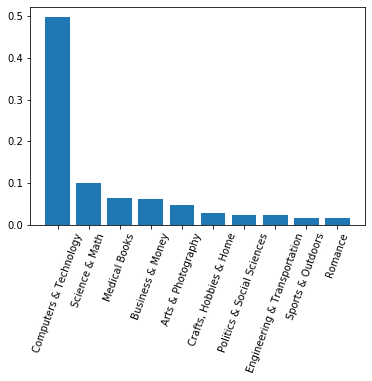

In [59]:
import matplotlib.pyplot as plt

# Plot class probabilities bar graph
plt.bar(range(len(prob_classes)), list(prob_classes.values()), align='center')
plt.xticks(range(len(prob_classes)), list(prob_classes.keys()), rotation=70)

## Prediction demo using deep models

We repeat this process again using one of our deep learning models:

In [1]:
# Read book title
book = "Principles of statistical learning"

# Filter book title data 
book = book.lower()
book = book.split()
ps = PorterStemmer()
book = [ps.stem(word) for word in book if not word in set(stopwords.words('english'))]
book = ' '.join(book)

# Tokenize and prepare sequence
x = sequence.pad_sequences(tokenizer.texts_to_sequences([book]), maxlen=100)
probs = lstm.predict_proba(x).reshape((32,)) 
   
# Create class to probability mappings
prob_classes = {k: v for k, v in zip(label_encoder.classes_, probs)}
prob_classes = OrderedDict(reversed(sorted(prob_classes.items(), key=lambda x: x[1])[-10:]))

# Plot class probabilities bar graph
plt.bar(range(len(prob_classes)), list(prob_classes.values()), align='center')
plt.xticks(range(len(prob_classes)), list(prob_classes.keys()), rotation=70)

NameError: name 'PorterStemmer' is not defined